# RBR Legato
Notebook that deals with the ship data, quality control, etc

## Load modules

In [1]:
%matplotlib inline
%pylab inline
import xarray as xr
import pandas as pd
import datetime
import glob
import matplotlib.dates as mdates
import gsw
import glidertools as gt
from tqdm.notebook import tqdm_notebook as tqdm
from cmocean import cm as cmo  
import os
import pathlib
from matplotlib.ticker import MaxNLocator
import geomag
import cartopy.crs as ccrs
import matplotlib
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.image as mpimg
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import scipy
import numpy as np
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.animation import FuncAnimation
import cartopy.feature as cfeature
import scipy.signal as sg  #Package for signal analysis
import scipy.ndimage as si #Another package for signal analysis
#from scipy.interpolate import interp1d  #for converting cell to grid-centered coordinates
#from scipy import stats    #Used for 2D binned statistics
#from mpl_toolkits.axes_grid1 import make_axes_locatable #For plotting interior colobars
#import cartopy.crs as ccrs
from scipy import stats
#from scipy import signal, ndimage
from scipy import fft as spfft
from scipy.fft import fft 
from scipy.stats import chi2
from scipy.special import digamma
from scipy.stats import pearsonr
#function for coverting Matlab's datenum into Python's datetime
#from https://gist.github.com/victorkristof/b9d794fe1ed12e708b9d
#with modifications to support array input and output

mpl.rcParams['animation.ffmpeg_path'] = r"/Users/xedhjo/Documents/Python/extra/ffmpeg"

font = {'family' : 'Avenir',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

mpl.rcParams['xtick.major.size'] = 8
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 8
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 4
mpl.rcParams['ytick.minor.width'] = 1

from IPython.display import display, Markdown

def print_with_font_size(text, fs=20):
    # Format the output with the desired font size
    print_output = f"<span style='font-size: {fs}px;'>{text}</span>"
    display(Markdown(print_output))

print = print_with_font_size

def rot_ticks(axs,rot,ha):
    for xlabels in axs.get_xticklabels():
                xlabels.set_rotation(rot)
                xlabels.set_ha(ha)
                
def time_ticks_h(ax,interval=[0,6,12,18]):
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M\n%d %b"))
    
def time_ticks_d(ax,majint,minint):
    ax.xaxis.set_minor_locator(mdates.HourLocator(minint))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter(""))
    ax.xaxis.set_major_locator(mdates.DayLocator(majint))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
    
def gridlines(ax,lon_tick,lat_tick):
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      x_inline=False, y_inline=False,
                  linewidth=0.75, alpha=0.5, linestyle='--',ylocs = matplotlib.ticker.MultipleLocator(base=lat_tick),xlocs = matplotlib.ticker.MultipleLocator(base=lon_tick))
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    gl.xpadding=10
    gl.ypadding=10
    
def corfreq(lat):
    """
    The Coriolis frequency in rad / day at a given latitude.
    
    Parameters
    ----------
        lat: Latitude in degree
        
    Returns:
        The Coriolis frequecy at latitude lat
    """    
    omega=7.2921159e-5;
    return 2*np.sin(lat*2*np.pi/360)*omega*(3600)*24


def fix_xticks(ax,ds):
    
    if (ds.time[-1] - ds.time[0]).data.astype('timedelta64[D]') < 1 :
        ax[0].xaxis.set_minor_locator(mdates.HourLocator())
        ax[0].xaxis.set_major_locator(mdates.HourLocator(np.arange(0,24,3)))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
        ax[0].xaxis.set_minor_formatter(mdates.DateFormatter(""))
        #ax[3].set_xlabel(f"{ds.time[0].values.astype('datetime64[D]')}",loc='left')

    if ((ds.time[-1] - ds.time[0]).data.astype('timedelta64[D]') > 1) and ((ds.time[-1] - ds.time[0]).data.astype('timedelta64[D]') < 7):
        ax[0].xaxis.set_minor_locator(mdates.HourLocator([0,12]))
        ax[0].xaxis.set_major_locator(mdates.DayLocator(np.arange(1,32,1)))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%d\n%b"))
        ax[0].xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))

    if ((ds.time[-1] - ds.time[0]).data.astype('timedelta64[D]') > 6) and ((ds.time[-1] - ds.time[0]).data.astype('timedelta64[D]') < 15):
        ax[0].xaxis.set_minor_locator(mdates.DayLocator(np.arange(1,32,1)))
        ax[0].xaxis.set_major_locator(mdates.DayLocator(np.arange(2,32,2)))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%d\n%b"))
        ax[0].xaxis.set_minor_formatter(mdates.DateFormatter(""))
        ax[-1].set_xlabel('2023')

    if ((ds.time[-1] - ds.time[0]).data.astype('timedelta64[D]') > 14) and ((ds.time[-1] - ds.time[0]).data.astype('timedelta64[D]') < 31):
        ax[0].xaxis.set_minor_locator(mdates.DayLocator(np.arange(1,32,1)))
        ax[0].xaxis.set_major_locator(mdates.DayLocator([5,10,15,20,25,30]))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%d\n%b"))
        #ax[0].xaxis.set_minor_formatter(mdates.DateFormatter("%d"))

    if ((ds.time[-1] - ds.time[0]).data.astype('timedelta64[D]') > 30):
        ax[0].xaxis.set_major_locator(mdates.MonthLocator())
        ax[0].xaxis.set_minor_locator(mdates.DayLocator([1,5,10,15,20,25]))
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%d\n%B"))
        ax[0].xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
    
    rot_ticks(ax[-1],0,'center')



wind_c2 = ListedColormap(['#FCC681','#FF819E','#FF819E','#A0A3E0','#A0A3E0','#99D4E5','#99D4E5','#FCC681']) # Soft pastels, use this

kc = '#006699'
sdc = '#ff6600'
ppc = 'crimson'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Load and transform the data

In [66]:
# Specify the input and output file names

rbr_files = glob.glob('/Users/xedhjo/Documents/Projects/QUICCHE/data/sailbuoy/PimPim/full/Legato/*.csv')

for file in tqdm(rbr_files):

    # Read the CSV file using pandas
    df = pd.read_csv(file,skiprows=1,sep=';')

    # Replace ',' with '.' in all columns
    df = df.replace(',', '.', regex=True)

    # Lower caps
    df.columns = df.columns.str.lower()

    # Save the modified DataFrame to a new CSV file
    df.to_csv(file, index=False)

  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/kv/12hx37w96j39x9h5z7hw8hy40000gn/T/ipykernel_59871/4270818306.py:8: DtypeWarning: Columns (6,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file,skiprows=1,sep=';')
/var/folders/kv/12hx37w96j39x9h5z7hw8hy40000gn/T/ipykernel_59871/4270818306.py:8: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file,skiprows=1,sep=';')


In [75]:
for file in tqdm(rbr_files):
    df = pd.read_csv(file,sep=',')
    df['time'] = df['time'].astype('datetime64[ns]')
    ds = df.set_index('time').to_xarray().sortby('time')
    ds.to_netcdf(file[:-3] + 'nc')

  0%|          | 0/8 [00:00<?, ?it/s]

In [117]:
ds.to_netcdf('/Users/xedhjo/Documents/Projects/QUICCHE/data/sailbuoy/PimPim/full/legato.nc')

## Open data

In [2]:
ds = xr.open_dataset('/Users/xedhjo/Documents/Projects/QUICCHE/data/sailbuoy/PimPim/full/legato.nc')

In [3]:
ds = ds.sel(time=slice('2023-03-22T06:00:00','2023-05-23T05:00'))

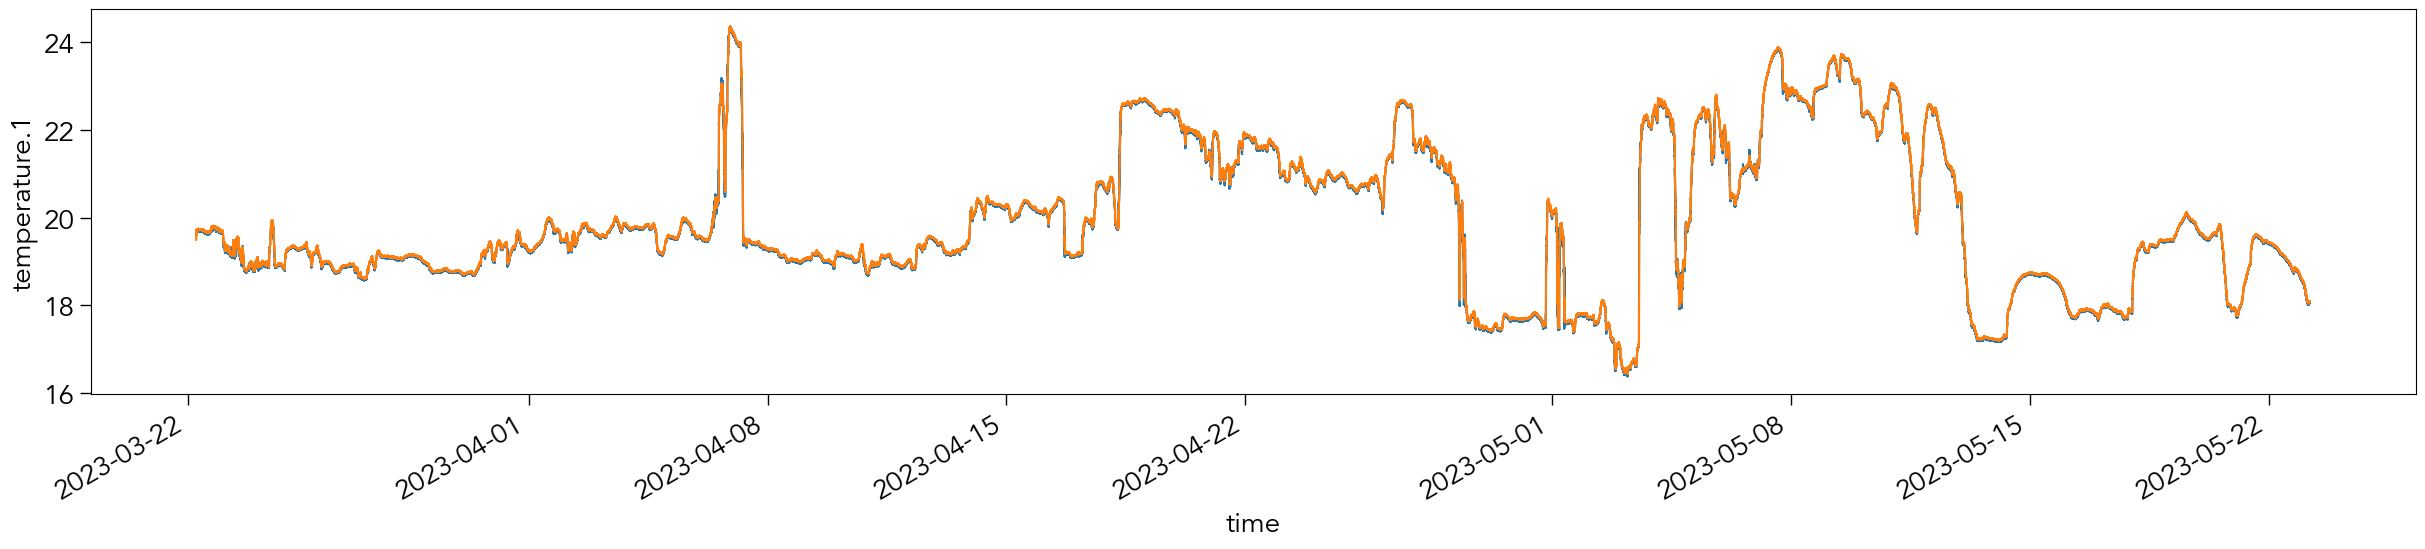

In [4]:
ds['temperature'].where(ds['salinity']>30).plot(figsize=(30,5))
ds['temperature.1'].where(ds['salinity']>30).plot()

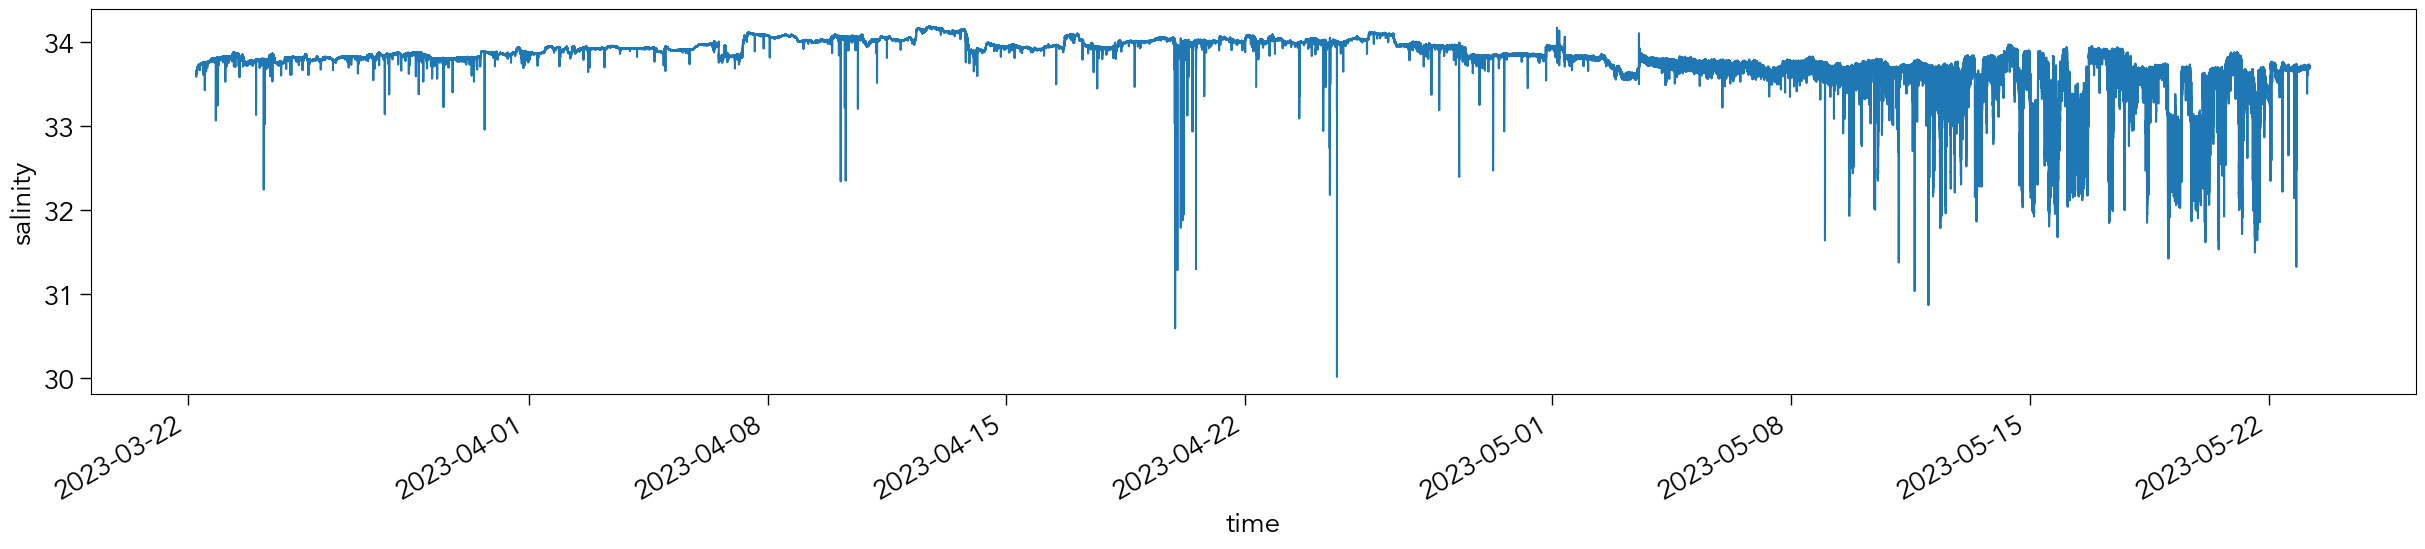

In [5]:
ds['salinity'].where(ds['salinity']>30).plot(figsize=(30,5))


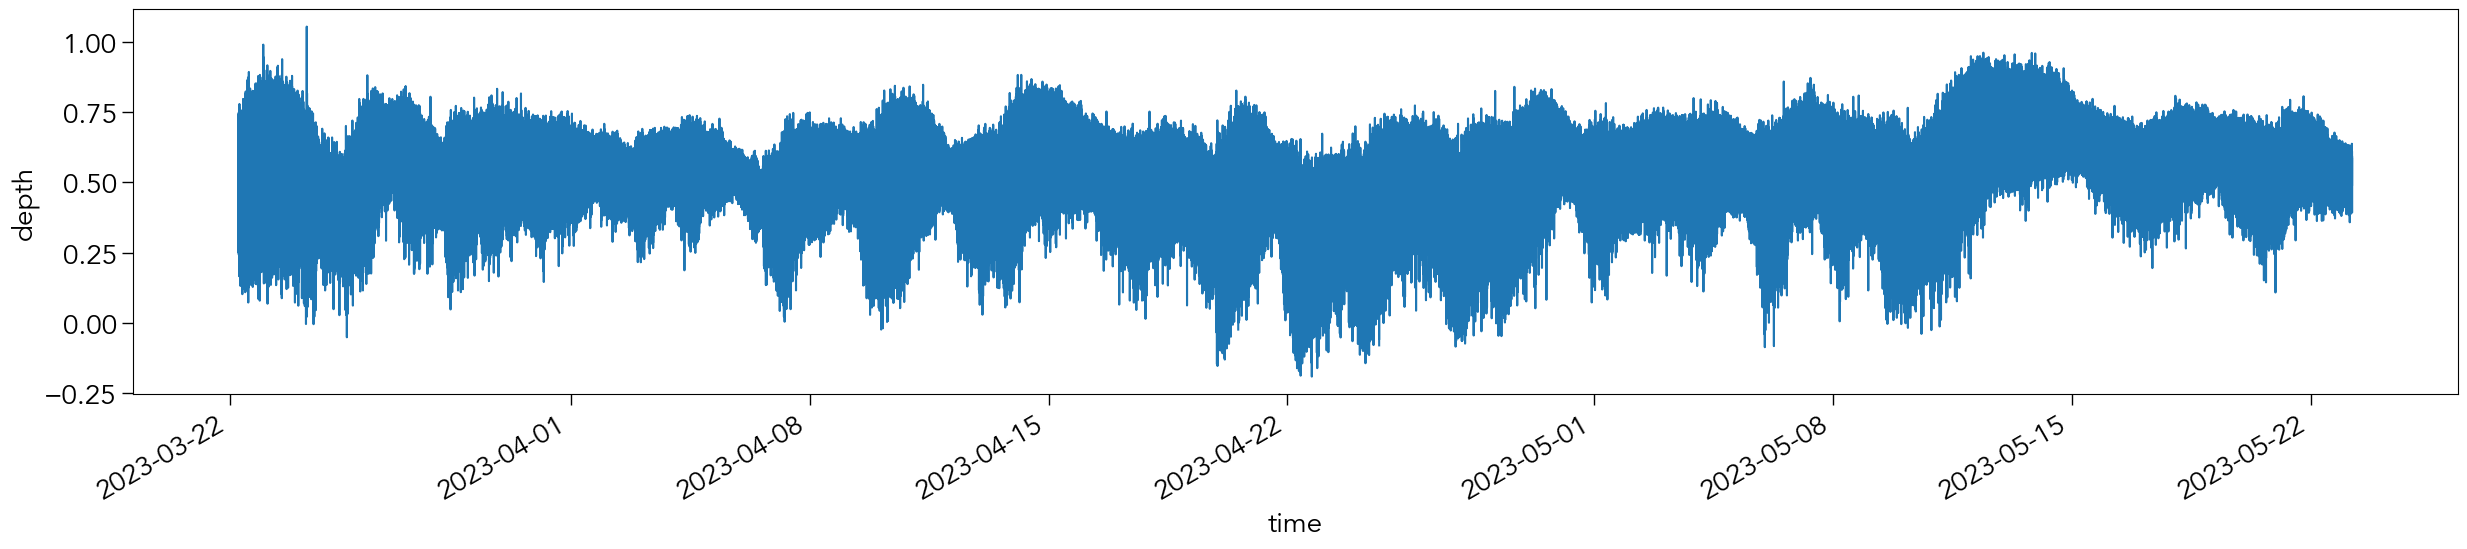

In [6]:
ds['depth'].where(ds['salinity']>30).plot(figsize=(30,5)) #.rolling(time=60,center=True).mean('time')